In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import numpy as np
import warnings
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
import pandas as pd
import requests

In [2]:
# https://api.v2.emissions-api.org/api/v2/carbonmonoxide/statistics.json?point=79.8412&point=6.9271&interval=day&begin=2019-01-01&end=2024-01-01&offset=0

In [55]:
def handle_dates(df):

    df['DATE'] = pd.to_datetime(df['DATE'].str[:10], format='%Y-%m-%d')
    df=df.sort_values(by=['DATE'])


    # Step 1: Check Time Range
    min_date = '2019-01-01'
    max_date = '2024-01-01'

    # Step 2: Generate Time Range
    complete_time_range = pd.date_range(start=min_date, end=max_date, freq='D')  
    # Step 3: Identify Missing Values
    missing_values = complete_time_range[~complete_time_range.isin(df['DATE'])]

    if len(missing_values) == 0:
        pass
    else:
        # Step 4: Create DataFrame for missing dates
        missing_df = pd.DataFrame({'DATE': missing_values})

        # Step 5: Concatenate missing dates DataFrame with existing DataFrame
        df = pd.concat([df, missing_df], ignore_index=True)
        df['DATE']=pd.to_datetime(df['DATE'])
        
        # Sort the DataFrame by 'DATE' column
        df=df.sort_values(by=['DATE'])
        df = df.reset_index(drop=True)
        
        print('Date column was succefully handled')
        return df
    




## Colombo

In [84]:
#import requests
#### Point
# API endpoint URL
url1 = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/statistics.json"
url2 = "https://api.v2.emissions-api.org/api/v2/nitrogendioxide/statistics.json"
#url3 = "https://api.v2.emissions-api.org/api/v2/methane/statistics.json"
url4= "https://api.v2.emissions-api.org/api/v2/ozone/statistics.json"



# Define query parameters
params = {
    "point": "79.8670,6.9000",  # Combine latitude and longitude with comma
    "interval": "day",
    "begin": "2019-01-01",
    "end": "2024-01-01",
}

# Send GET request with parameters
response1 = requests.get(url1, params=params)
response2 = requests.get(url2, params=params)
response3 = requests.get(url3, params=params)
response4 = requests.get(url4, params=params)

data1 = response1.json()
data2 = response2.json()
#data3 = response3.json()
data4 = response4.json()
all_datasets=[]
for [i,j] in [[data1,'carbonmonoxide'],[data2,'nitrogendioxide'],[data4,'ozone']]:
    extracted_data=[]
    for entry in i:
        extracted_data.append({
            "DATE": entry["time"]["interval_start"],
            f"{j}_average": entry["value"]["average"],
        })
    df = pd.DataFrame(extracted_data)
    all_datasets.append(handle_dates(df))



Date column was succefully handled
Date column was succefully handled
Date column was succefully handled


In [85]:
# Merge datasets based on the 'DATE' column
cmb = pd.merge(all_datasets[0], all_datasets[1], on='DATE')
for i in all_datasets[2:]:
    cmb = pd.merge(cmb, i, on='DATE', how='inner')
cmb.head(20)

,DATE,carbonmonoxide_average,nitrogendioxide_average,ozone_average
0,2019-01-01,0.040408,0.000030,NaN
1,2019-01-02,NaN,0.000031,NaN
2,2019-01-03,0.034717,0.000025,NaN
3,2019-01-04,0.036808,0.000029,NaN
4,2019-01-05,0.035529,0.000026,NaN
5,2019-01-06,0.032193,0.000032,NaN
6,2019-01-07,0.034157,0.000036,NaN
7,2019-01-08,0.036049,0.000031,NaN
8,2019-01-09,0.039724,0.000030,NaN
9,2019-01-10,0.038811,0.000034,NaN


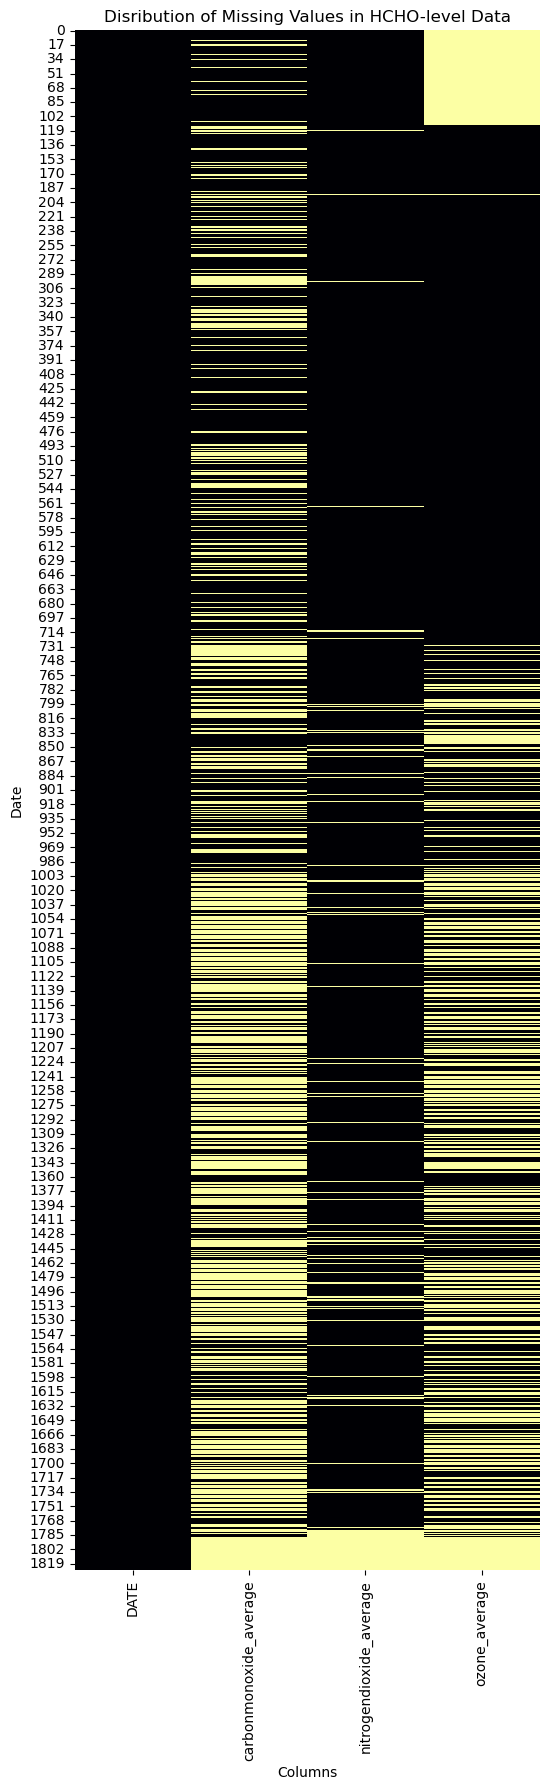

DATE                         0
carbonmonoxide_average     796
nitrogendioxide_average    133
ozone_average              607
dtype: int64

In [80]:
import seaborn as sns

# Visualize missing values using a heatmap
plt.figure(figsize=(6, 20))
sns.heatmap(cmb.isnull(), cbar=False, cmap='inferno')
plt.title('Disribution of Missing Values in HCHO-level Data')
plt.xlabel('Columns')
plt.ylabel('Date')
plt.show()

cmb.isnull().sum()

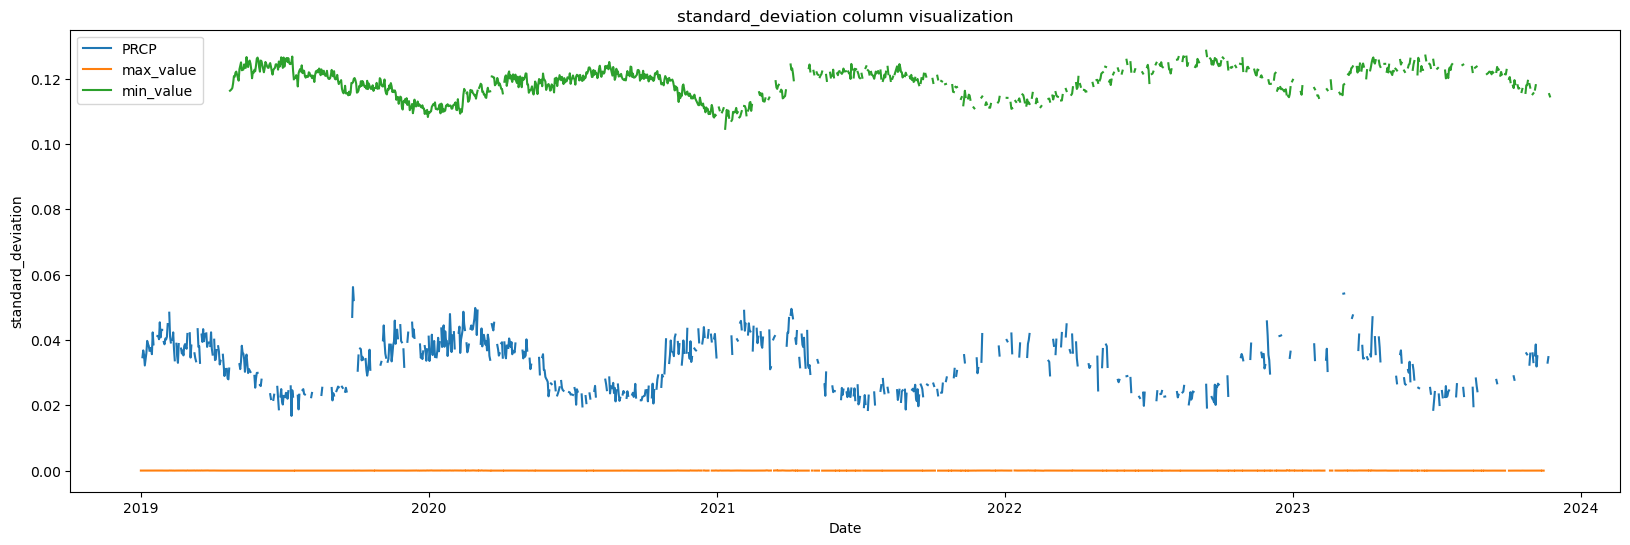

In [76]:
# Create the plot
column="standard_deviation"
plt.figure(figsize=(20, 6))
plt.plot( cmb['DATE'], cmb['carbonmonoxide_average'], label="PRCP")
plt.plot( cmb['DATE'], cmb['nitrogendioxide_average'], label="max_value")
plt.plot( cmb['DATE'], cmb['ozone_average'], label="min_value")
plt.title(f"{column} column visualization")
plt.xlabel("Date")
plt.ylabel(column)
plt.legend()
plt.show()

Previous: 923
After: 630


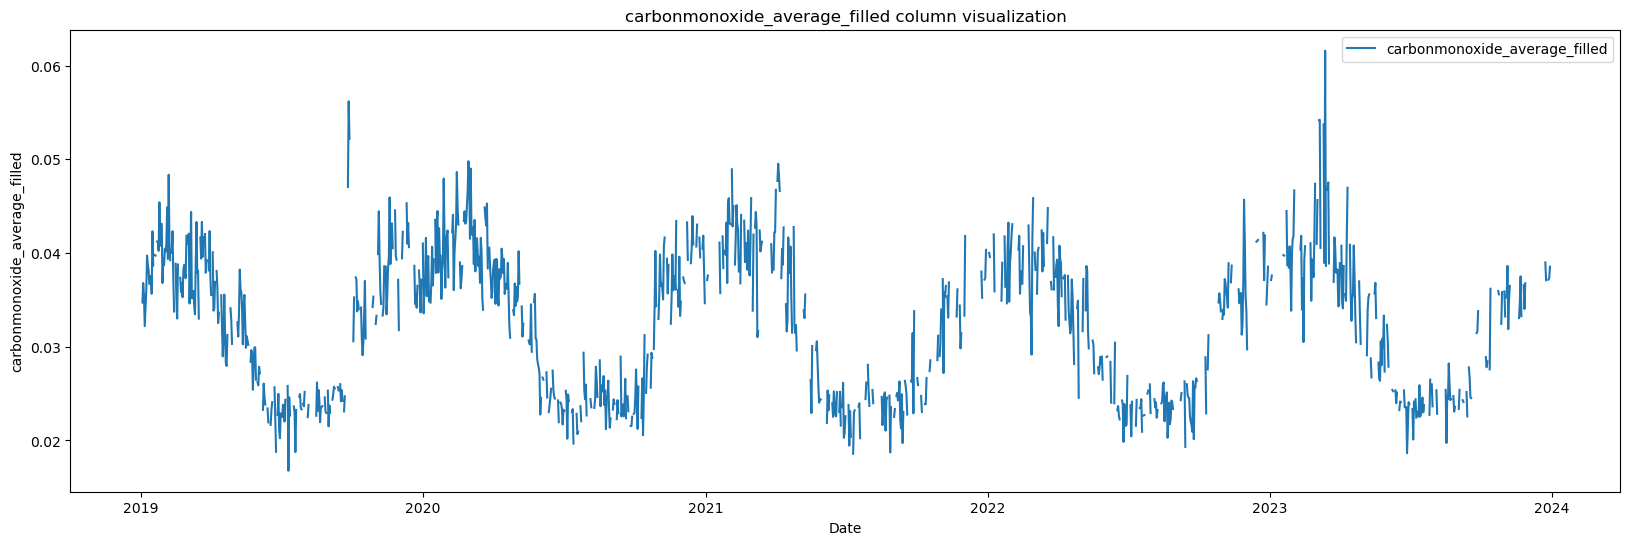

Previous: 630
After: 14


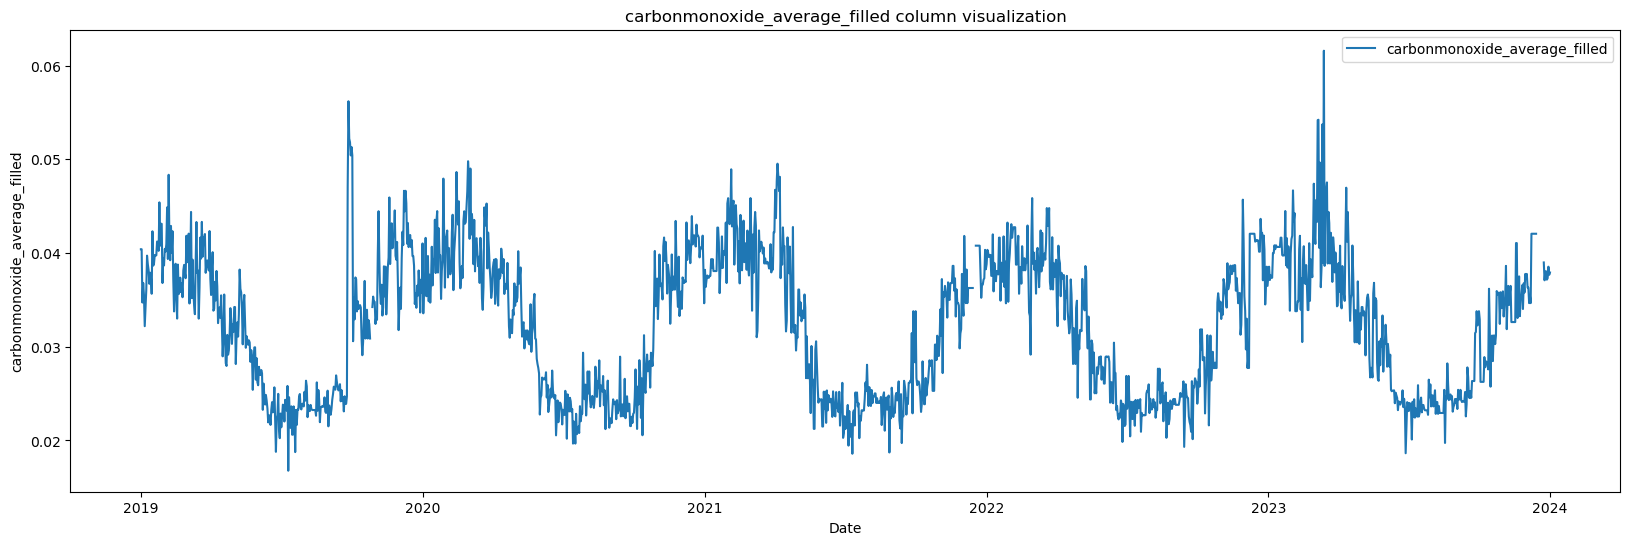

In [86]:
cmb['carbonmonoxide_average_filled'] = cmb['carbonmonoxide_average']
cmb.set_index('DATE', inplace=True)
# Define the time range
start_date = '2019-01-01'
end_date = '2024-01-01'

# Generate a DataFrame with the range of dates
date_range = pd.date_range(start=start_date, end=end_date, freq='D')



# Iterate over each null value
for index, row in cmb[cmb['carbonmonoxide_average_filled'].isnull()].iterrows():
    # Get the date of the null value
    null_date = row.name
    
    # Extract the month and day of the null date
    month_day = (null_date.month, null_date.day)
    
    # Filter the DataFrame to include only rows with the same month and day
    same_day_rows = cmb[(cmb.index.month == month_day[0]) & (cmb.index.day == month_day[1])]
    
    if same_day_rows['carbonmonoxide_average_filled'].isnull().sum()<3:
    
        # Exclude the null value itself
        same_day_rows = same_day_rows[same_day_rows.index != null_date]

        # Calculate the mean of the non-null values for the same day across years
        mean_value = same_day_rows['carbonmonoxide_average_filled'].mean()

        # Fill the null value with the mean
        cmb.at[null_date, 'carbonmonoxide_average_filled'] = mean_value
        
print('Previous:', cmb['carbonmonoxide_average'].isnull().sum())
print('After:' ,cmb['carbonmonoxide_average_filled'].isnull().sum())

# Display the DataFrame with the filled values
plt.figure(figsize=(20, 6))
plt.plot(cmb.index, cmb['carbonmonoxide_average_filled'], label='carbonmonoxide_average_filled')
plt.title("carbonmonoxide_average_filled column visualization")
plt.xlabel("Date")
plt.ylabel("carbonmonoxide_average_filled")
plt.legend()
plt.show()

print('Previous:', cmb['carbonmonoxide_average_filled'].isnull().sum())
cmb['carbonmonoxide_average_filled']=cmb['carbonmonoxide_average_filled'].fillna(cmb['carbonmonoxide_average_filled'].rolling(window=4, min_periods=1).mean())
cmb['carbonmonoxide_average_filled']=cmb['carbonmonoxide_average_filled'].fillna(cmb['carbonmonoxide_average_filled'].rolling(window=4, min_periods=1).mean())
print('After:' ,cmb['carbonmonoxide_average_filled'].isnull().sum())

# Display the DataFrame with the filled values
plt.figure(figsize=(20, 6))
plt.plot(cmb.index, cmb['carbonmonoxide_average_filled'], label='carbonmonoxide_average_filled')
plt.title("carbonmonoxide_average_filled column visualization")
plt.xlabel("Date")
plt.ylabel("carbonmonoxide_average_filled")
plt.legend()
plt.show()

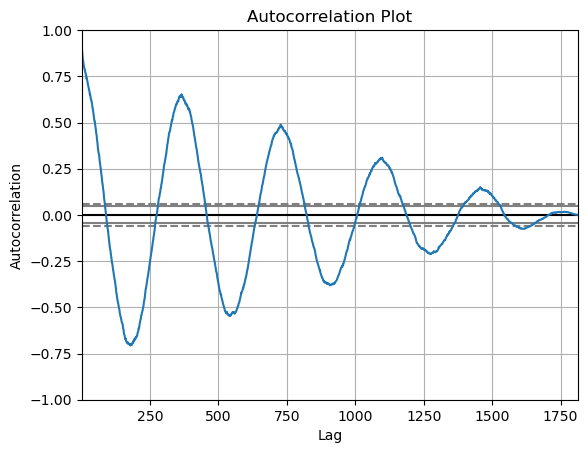

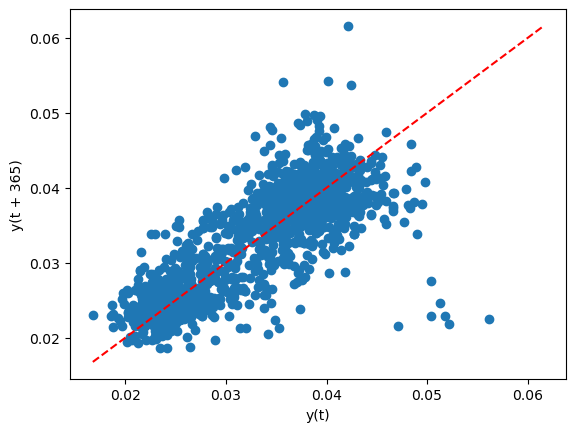

In [91]:
pd.plotting.autocorrelation_plot(cmb[['carbonmonoxide_average_filled']].dropna())
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Create the lag plot
lag_plot = pd.plotting.lag_plot(cmb[['carbonmonoxide_average_filled']].dropna(), lag=365)

# Add y=x line
plt.plot([cmb['carbonmonoxide_average_filled'].min(), cmb['carbonmonoxide_average_filled'].max()],
         [cmb['carbonmonoxide_average_filled'].min(), cmb['carbonmonoxide_average_filled'].max()],
         linestyle='--', color='red')

plt.show()


## Kurunagala

In [69]:
#import requests
#### Point
# API endpoint URL
url1 = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/statistics.json"
url2 = "https://api.v2.emissions-api.org/api/v2/nitrogendioxide/statistics.json"
#url3 = "https://api.v2.emissions-api.org/api/v2/methane/statistics.json"
url4= "https://api.v2.emissions-api.org/api/v2/ozone/statistics.json"



polygon = "80.3485,7.4954,80.3754,7.4954,80.3754,7.2677,80.3485,7.2677,80.3485,7.4954"

# Define query parameters
params = {
    "polygon": polygon,
    "interval": "day",
    "begin": "2019-01-01",
    "end": "2024-01-01"
}


# Send GET request with parameters
response1 = requests.get(url1, params=params)
response2 = requests.get(url2, params=params)
response3 = requests.get(url3, params=params)
response4 = requests.get(url4, params=params)

data1 = response1.json()
data2 = response2.json()
#data3 = response3.json()
data4 = response4.json()
all_datasets=[]
for [i,j] in [[data1,'carbonmonoxide'],[data2,'nitrogendioxide'],[data4,'ozone']]:
    extracted_data=[]
    for entry in i:
        extracted_data.append({
            "DATE": entry["time"]["interval_start"],
            f"{j}_average": entry["value"]["average"],
        })
    df = pd.DataFrame(extracted_data)
    all_datasets.append(handle_dates(df))

# Merge datasets based on the 'DATE' column
kur = pd.merge(all_datasets[0], all_datasets[1], on='DATE')
for i in all_datasets[2:]:
    kur = pd.merge(kur, i, on='DATE', how='inner')
kur.head(20)

Date column was succefully handled
Date column was succefully handled
Date column was succefully handled


,DATE,carbonmonoxide_average,nitrogendioxide_average,ozone_average
0,2019-01-01,0.035947,0.000017,NaN
1,2019-01-02,0.036163,0.000016,NaN
2,2019-01-03,0.032443,0.000019,NaN
3,2019-01-04,0.034312,0.000011,NaN
4,2019-01-05,0.033251,0.000018,NaN
5,2019-01-06,0.031712,0.000016,NaN
6,2019-01-07,0.035361,0.000023,NaN
7,2019-01-08,0.034584,0.000023,NaN
8,2019-01-09,0.034852,0.000018,NaN
9,2019-01-10,0.036023,0.000021,NaN


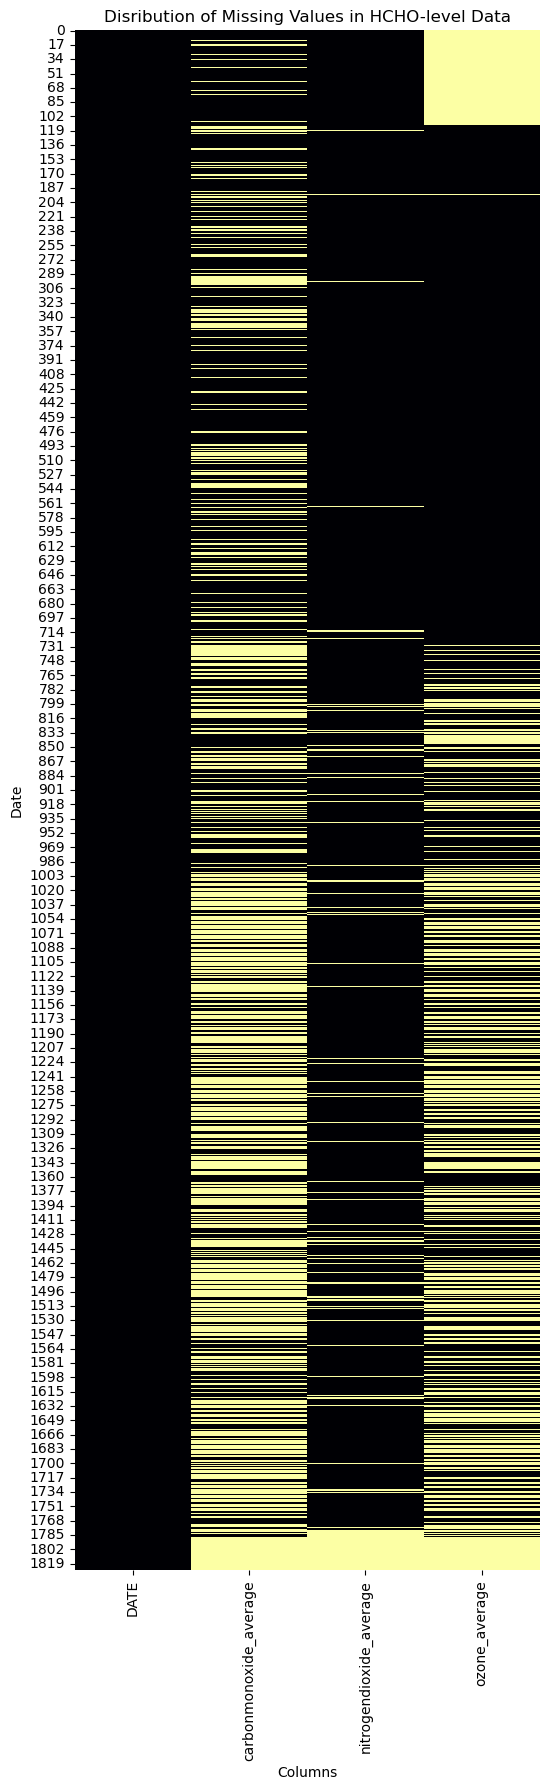

DATE                         0
carbonmonoxide_average     796
nitrogendioxide_average    133
ozone_average              607
dtype: int64

In [71]:
import seaborn as sns

# Visualize missing values using a heatmap
plt.figure(figsize=(6, 20))
sns.heatmap(kur.isnull(), cbar=False, cmap='inferno')
plt.title('Disribution of Missing Values in HCHO-level Data')
plt.xlabel('Columns')
plt.ylabel('Date')
plt.show()

kur.isnull().sum()

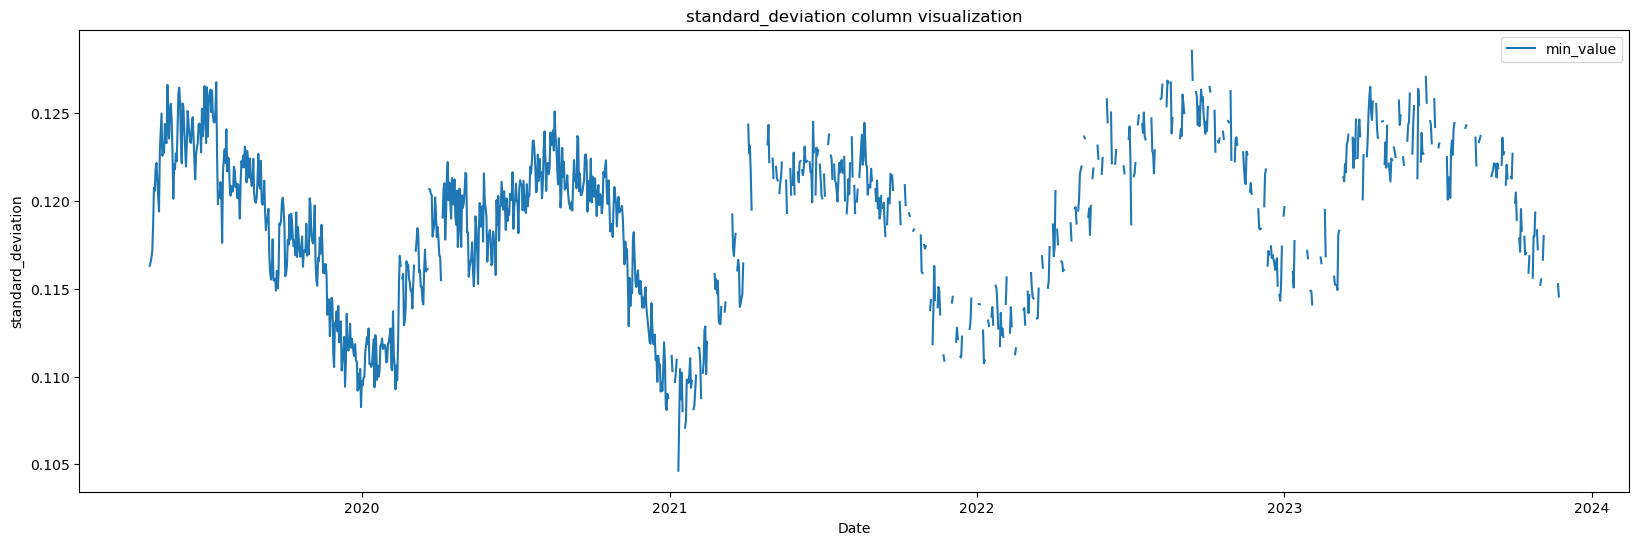

In [75]:
# Create the plot
column="standard_deviation"
plt.figure(figsize=(20, 6))
plt.plot( kur['DATE'], kur['carbonmonoxide_average'], label="PRCP")
plt.plot( kur['DATE'], kur['nitrogendioxide_average'], label="max_value")
plt.plot( kur['DATE'], kur['ozone_average'], label="min_value")
plt.title(f"{column} column visualization")
plt.xlabel("Date")
plt.ylabel(column)
plt.legend()
plt.show()

In [68]:
import requests

# API endpoint URL
url = "https://api.v2.emissions-api.org/api/v2/methane/statistics.json"

# Define query parameters
params = {
    "point": "79.8412,6.9271",  # Combine latitude and longitude with comma
    "interval": "day",
    "begin": "2019-01-01",
    "end": "2024-01-01",
    "offset": 0
}

# Send GET request with parameters
response = requests.get(url, params=params)

# Check for successful response
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()
    print(data)
else:
    print(f"Error: API request failed with status code {response.status_code}")


[{'time': {'interval_start': '2023-10-26T00:00:00Z', 'max': '2023-10-26T10:00:27.523000Z', 'min': '2023-10-26T10:00:27.523000Z'}, 'value': {'average': 1948.5660400390625, 'count': 1, 'max': 1948.5660400390625, 'min': 1948.5660400390625, 'standard deviation': None}}, {'time': {'interval_start': '2023-05-25T00:00:00Z', 'max': '2023-05-25T09:49:49.451000Z', 'min': '2023-05-25T09:49:49.451000Z'}, 'value': {'average': 1860.02001953125, 'count': 1, 'max': 1860.02001953125, 'min': 1860.02001953125, 'standard deviation': None}}, {'time': {'interval_start': '2021-12-07T00:00:00Z', 'max': '2021-12-07T08:59:41.437000Z', 'min': '2021-12-07T08:59:41.437000Z'}, 'value': {'average': 1968.89599609375, 'count': 1, 'max': 1968.89599609375, 'min': 1968.89599609375, 'standard deviation': None}}, {'time': {'interval_start': '2023-03-22T00:00:00Z', 'max': '2023-03-22T08:48:40.322000Z', 'min': '2023-03-22T08:48:40.322000Z'}, 'value': {'average': 1887.722412109375, 'count': 1, 'max': 1887.722412109375, 'min':

In [45]:
## polygon

# API endpoint URL
url = "https://api.v2.emissions-api.org/api/v2/methane/statistics.json"

# Define polygon coordinates (replace with your desired coordinates)
# Ensure the order forms a closed loop
polygon = "80.3485,7.4954,80.3754,7.4954,80.3754,7.2677,80.3485,7.2677,80.3485,7.4954"

# Define query parameters
params = {
    "polygon": polygon,
    "interval": "day",
    "begin": "2019-01-01",
    "end": "2024-01-01"
}

# Send GET request with parameters
response = requests.get(url, params=params)

# Check for successful response
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()
    print(data)
else:
    print(f"Error: API request failed with status code {response.status_code}")


[{'time': {'interval_start': '2019-01-03T00:00:00Z', 'max': '2019-01-03T08:44:02.041000Z', 'min': '2019-01-03T08:44:02.041000Z'}, 'value': {'average': 1855.97802734375, 'count': 1, 'max': 1855.97802734375, 'min': 1855.97802734375, 'standard deviation': None}}, {'time': {'interval_start': '2019-01-04T00:00:00Z', 'max': '2019-01-04T08:25:03.110000Z', 'min': '2019-01-04T08:25:03.110000Z'}, 'value': {'average': 1876.2943115234375, 'count': 1, 'max': 1876.2943115234375, 'min': 1876.2943115234375, 'standard deviation': None}}, {'time': {'interval_start': '2019-01-06T00:00:00Z', 'max': '2019-01-06T07:47:31.796000Z', 'min': '2019-01-06T07:47:31.796000Z'}, 'value': {'average': 1871.22900390625, 'count': 1, 'max': 1871.22900390625, 'min': 1871.22900390625, 'standard deviation': None}}, {'time': {'interval_start': '2019-01-10T00:00:00Z', 'max': '2019-01-10T08:12:31.138000Z', 'min': '2019-01-10T08:12:31.138000Z'}, 'value': {'average': 1871.158447265625, 'count': 1, 'max': 1871.158447265625, 'min':

In [5]:
#### Country
# API endpoint URL
url = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/statistics.json"

# Define query parameters
params = {
    "country": "LKA",
    "interval": "day",
    "begin": "2019-01-01",
    "end": "2024-01-01"
}

# Send GET request with parameters
response = requests.get(url, params=params)

# Check for successful response
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()
    print(data)
else:
    print(f"Error: API request failed with status code {response.status_code}")

[{'time': {'interval_start': '2019-01-01T00:00:00Z', 'max': '2019-01-01T07:41:54.318000Z', 'min': '2019-01-01T07:41:00.319000Z'}, 'value': {'average': 0.035189210961107165, 'count': 32, 'max': 0.03734779357910156, 'min': 0.028825627639889717, 'standard deviation': 0.0016783119893809047}}, {'time': {'interval_start': '2019-01-02T00:00:00Z', 'max': '2019-01-02T07:23:22.827000Z', 'min': '2019-01-02T07:22:28.828000Z'}, 'value': {'average': 0.03439335140865296, 'count': 32, 'max': 0.037021756172180176, 'min': 0.030499465763568878, 'standard deviation': 0.001360534892436207}}, {'time': {'interval_start': '2019-01-03T00:00:00Z', 'max': '2019-01-03T08:44:38.760000Z', 'min': '2019-01-03T08:43:40.441000Z'}, 'value': {'average': 0.032695242669433355, 'count': 32, 'max': 0.03424683213233948, 'min': 0.030029287561774254, 'standard deviation': 0.0010852233237433461}}, {'time': {'interval_start': '2019-01-04T00:00:00Z', 'max': '2019-01-04T08:25:39.829000Z', 'min': '2019-01-04T08:24:43.670000Z'}, 'val

In [28]:
extracted_data = []
for entry in data:
    extracted_data.append({
        "interval_start": entry["time"]["interval_start"],
#         "max_time": entry["time"]["max"],
#         "min_time": entry["time"]["min"],
        "average": entry["value"]["average"],
#         "count": entry["value"]["count"],
#         "max_value": entry["value"]["max"],
#         "min_value": entry["value"]["min"],
#         "standard_deviation": entry["value"]["standard deviation"]
    })

# Create DataFrame
df = pd.DataFrame(extracted_data)
df

,interval_start,max_time,min_time,average,count,max_value,min_value,standard_deviation
0,2020-11-23T00:00:00Z,2020-11-23T09:05:29.167000Z,2020-11-23T09:05:29.167000Z,0.000010,1,0.000010,0.000010,None
1,2019-03-02T00:00:00Z,2019-03-02T09:56:19.030000Z,2019-03-02T09:56:19.030000Z,0.000032,1,0.000032,0.000032,None
2,2019-02-24T00:00:00Z,2019-02-24T08:28:44.311000Z,2019-02-24T08:28:44.311000Z,0.000041,1,0.000041,0.000041,None
3,2022-10-08T00:00:00Z,2022-10-08T09:40:44.272000Z,2022-10-08T09:40:44.272000Z,0.000019,1,0.000019,0.000019,None
4,2019-10-18T00:00:00Z,2019-10-18T10:43:15.464000Z,2019-10-18T10:43:15.464000Z,0.000023,1,0.000023,0.000023,None
...,...,...,...,...,...,...,...,...
1682,2019-05-30T00:00:00Z,2019-05-30T09:46:42.728000Z,2019-05-30T09:46:42.728000Z,0.000024,1,0.000024,0.000024,None
1683,2022-09-20T00:00:00Z,2022-09-20T10:18:10.158000Z,2022-09-20T10:18:10.158000Z,0.000012,1,0.000012,0.000012,None
1684,2019-02-27T00:00:00Z,2019-02-27T09:12:11.539000Z,2019-02-27T09:12:11.539000Z,0.000026,1,0.000026,0.000026,None
1685,2020-07-05T00:00:00Z,2020-07-05T10:49:24.262000Z,2020-07-05T10:49:24.262000Z,0.000011,1,0.000011,0.000011,None


In [7]:
df.describe()

,average,count,max_value,min_value,standard_deviation
count,1296.000000,1296.00000,1296.000000,1296.000000,1278.000000
mean,0.030936,25.24537,0.034193,0.026629,0.001902
std,0.006339,8.60708,0.006990,0.005685,0.000711
min,0.019091,1.00000,0.020698,0.013901,0.000173
25%,0.024593,21.00000,0.027389,0.021516,0.001416
50%,0.031664,30.00000,0.034863,0.026980,0.001778
75%,0.035837,32.00000,0.039448,0.030896,0.002212
max,0.054968,32.00000,0.060332,0.052009,0.006292


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   interval_start      1296 non-null   object 
 1   max_time            1296 non-null   object 
 2   min_time            1296 non-null   object 
 3   average             1296 non-null   float64
 4   count               1296 non-null   int64  
 5   max_value           1296 non-null   float64
 6   min_value           1296 non-null   float64
 7   standard_deviation  1278 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 81.1+ KB


In [29]:
df['interval_start'] = pd.to_datetime(df['interval_start'].str[:10], format='%Y-%m-%d')
df=df.sort_values(by=['interval_start'])

In [30]:
# Step 1: Check Time Range
min_date = '2019-01-01'
max_date = '2024-01-01'
print("Time Range: From", min_date, "to", max_date)

# Step 2: Generate Time Range
complete_time_range = pd.date_range(start=min_date, end=max_date, freq='D')  
# Step 3: Identify Missing Values
missing_values = complete_time_range[~complete_time_range.isin(df['interval_start'])]

if len(missing_values) == 0:
    print("No missing dates found in the time range.")
else:
    print("Missing dates found:")
    print('Count: ',len(missing_values))
    print(missing_values)


Time Range: From 2019-01-01 to 2024-01-01
Missing dates found:
Count:  140
DatetimeIndex(['2019-07-15', '2019-10-24', '2020-02-17', '2020-03-04',
               '2020-03-20', '2020-04-05', '2020-05-15', '2020-07-19',
               '2020-07-28', '2020-12-13',
               ...
               '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
               '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
               '2023-12-31', '2024-01-01'],
              dtype='datetime64[ns]', length=140, freq=None)


In [31]:
# Step 4: Create DataFrame for missing dates
missing_df = pd.DataFrame({'interval_start': missing_values})

# Step 5: Concatenate missing dates DataFrame with existing DataFrame
df = pd.concat([df, missing_df], ignore_index=True)
df['interval_start']=pd.to_datetime(df['interval_start'])
# Sort the DataFrame by 'DATE' column
df=df.sort_values(by=['interval_start'])
df = df.reset_index(drop=True)



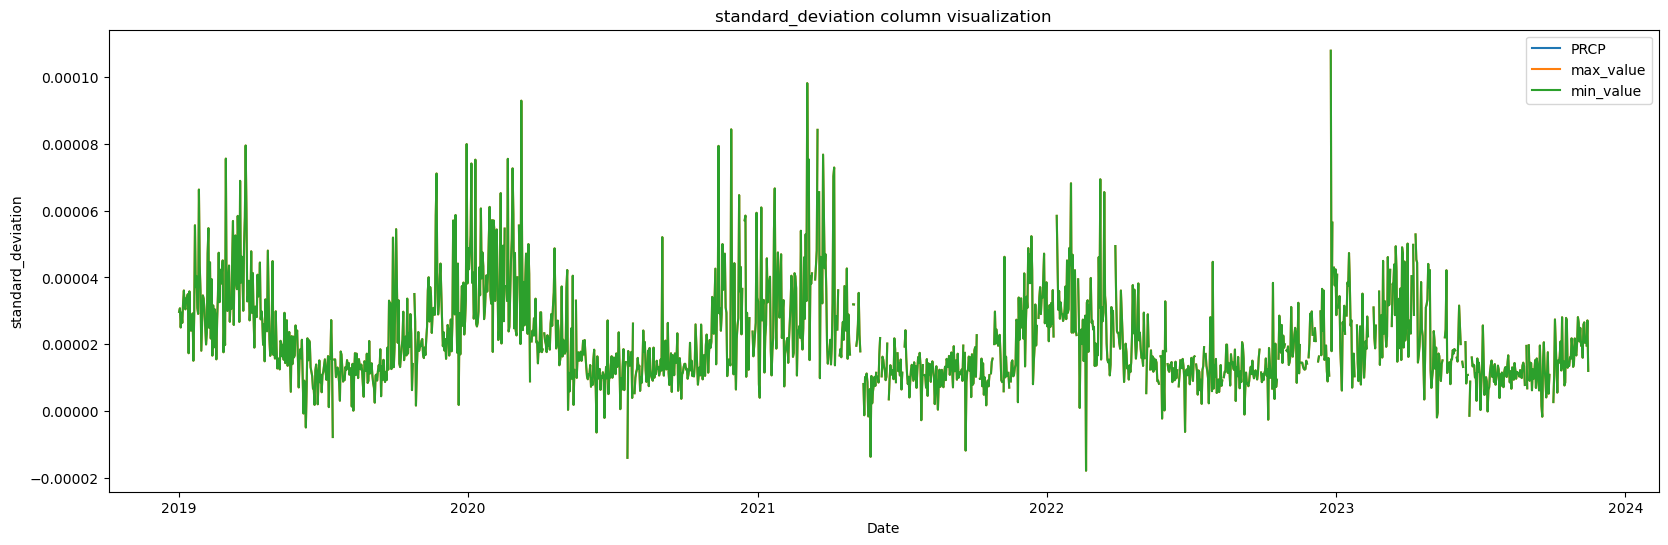

In [35]:
# Create the plot
column="standard_deviation"
plt.figure(figsize=(20, 6))
plt.plot( df['interval_start'], df[column], label="PRCP")
plt.plot( df['interval_start'], df['max_value'], label="max_value")
plt.plot( df['interval_start'], df['min_value'], label="min_value")
plt.title(f"{column} column visualization")
plt.xlabel("Date")
plt.ylabel(column)
plt.legend()
plt.show()

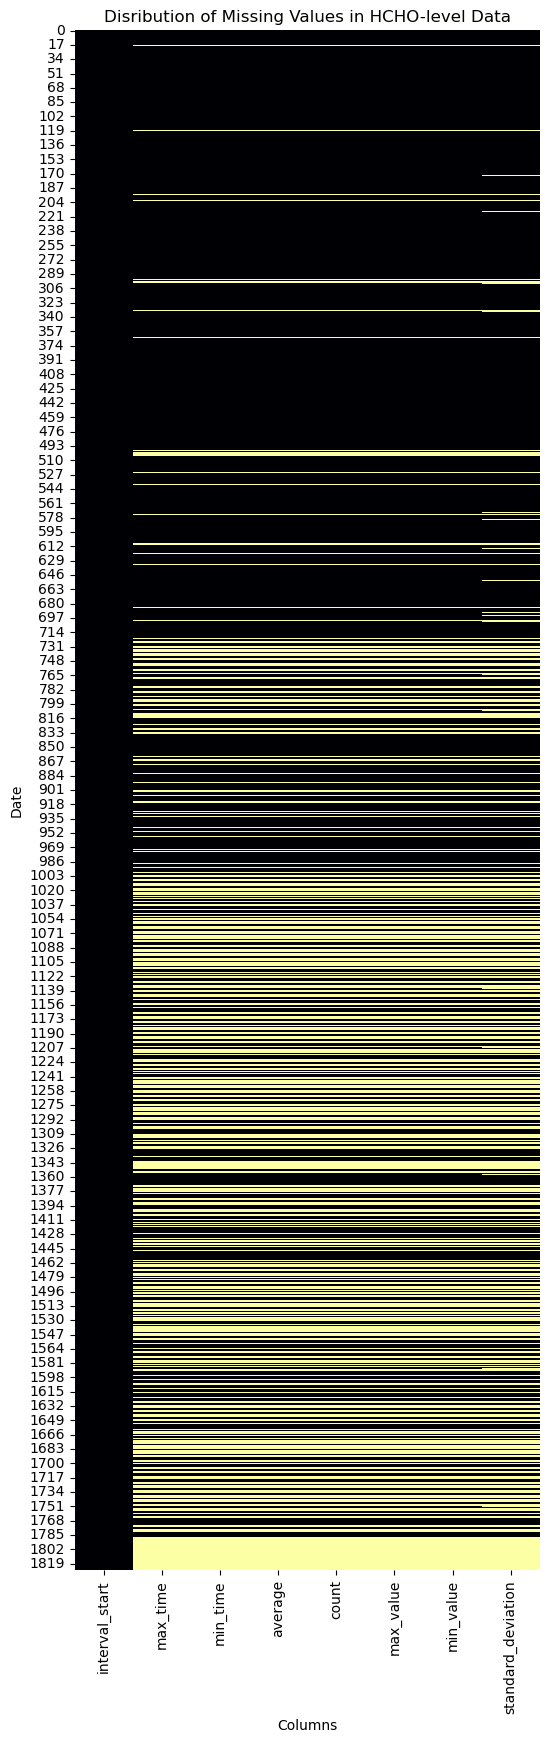

In [19]:
import seaborn as sns

# Visualize missing values using a heatmap
plt.figure(figsize=(6, 20))
sns.heatmap(df.isnull(), cbar=False, cmap='inferno')
plt.title('Disribution of Missing Values in HCHO-level Data')
plt.xlabel('Columns')
plt.ylabel('Date')
plt.show()

In [36]:
df.head(20)

,interval_start,max_time,min_time,average,count,max_value,min_value,standard_deviation
0,2019-01-01,2019-01-01T08:41:15.440000Z,2019-01-01T08:41:15.440000Z,0.000030,1.0,0.000030,0.000030,None
1,2019-01-02,2019-01-02T08:22:42.869000Z,2019-01-02T08:22:42.869000Z,0.000031,1.0,0.000031,0.000031,None
2,2019-01-03,2019-01-03T09:43:49.082000Z,2019-01-03T09:43:49.082000Z,0.000025,1.0,0.000025,0.000025,None
3,2019-01-04,2019-01-04T09:24:54.471000Z,2019-01-04T09:24:54.471000Z,0.000029,1.0,0.000029,0.000029,None
4,2019-01-05,2019-01-05T09:06:06.298000Z,2019-01-05T09:06:06.298000Z,0.000026,1.0,0.000026,0.000026,None
5,2019-01-06,2019-01-06T08:47:26.397000Z,2019-01-06T08:47:26.397000Z,0.000032,1.0,0.000032,0.000032,None
6,2019-01-07,2019-01-07T08:28:52.976000Z,2019-01-07T08:28:52.976000Z,0.000036,1.0,0.000036,0.000036,None
7,2019-01-08,2019-01-08T09:50:07.582000Z,2019-01-08T09:50:07.582000Z,0.000031,1.0,0.000031,0.000031,None
8,2019-01-09,2019-01-09T09:31:12.116000Z,2019-01-09T09:31:12.116000Z,0.000030,1.0,0.000030,0.000030,None
9,2019-01-10,2019-01-10T09:12:21.419000Z,2019-01-10T09:12:21.419000Z,0.000034,1.0,0.000034,0.000034,None


In [37]:
//

SyntaxError: invalid syntax (411536581.py, line 1)

In [ ]:
import requests

# API endpoint URL
url = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/statistics.json"

# Define query parameters
params = {
    "polygon": "79.90,6.75,79.95,6.95",  # Combine latitude and longitude with comma
    "interval": "day",
    "begin": "2019-01-01",
    "end": "2024-01-01",
    "offset": 0
}

# lat1: 6.75
# lat2: 6.95
# lon1: 79.90
# lon2: 79.95

# Send GET request with parameters
response = requests.get(url, params=params)

# Check for successful response
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()
    print(data)
else:
    print(f"Error: API request failed with status code {response.status_code}")


In [ ]:
#### Country
# API endpoint URL
url = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/statistics.json"

# Define query parameters
params = {
    "country": "LKA",
    "interval": "day",
    "begin": "2019-01-01",
    "end": "2024-01-01"
}

# Send GET request with parameters
response = requests.get(url, params=params)

# Check for successful response
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()
    print(data)
else:
    print(f"Error: API request failed with status code {response.status_code}")


# Monaragala

In [ ]:
import requests
#### Point
# API endpoint URL
url = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/statistics.json"

# Define query parameters
params = {
    "point": "81.3489,6.8719",  # Combine latitude and longitude with comma
    "interval": "day",
    "begin": "2019-01-01",
    "end": "2024-01-01",
    "offset": 0
}

# Send GET request with parameters
response = requests.get(url, params=params)

# Check for successful response
if response.status_code == 200:
    # Parse the JSON data
    data = response.json()
    print(data)
else:
    print(f"Error: API request failed with status code {response.status_code}")
